## Предсказание стоимости жилья

В проекте нам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели будем использовать метрики RMSE, MAE и R2.

***Цель: обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве — median_house_value.***

# Подготовка данных

импортируем необходимые библиотеки, запускаем Spark, инициализируем сессию, загружаем датасет и читаем данные из файла. Изучаем основную информацию по датасету.

In [73]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml import Pipeline
pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 2022



In [74]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Housing - Logistic regression") \
                    .getOrCreate()

df = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True)
df.printSchema()
df.show(10)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

выведем названия колонок и тип данных

In [75]:

print(pd.DataFrame(df.dtypes, columns=['column', 'type']).head(10))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


изучим кол-во пропусков в датасете: выведем кол-во пропущенных значений для каждого столбца

In [76]:
columns = df.columns

for column in columns:
    check_col = F.col(column).cast(FloatType())
    print(column, df.filter(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


аналогичное действие можно выполнить через трансформацию датасета в Pandas

по признаку total_bedrooms мы видим 207 пропусков, по остальным полям пропусков нет. Заполним пропуски медианными значениями. Для начала, сгруппируем данные по признаку количество ванных - близость от океана и попробуем изучить полученные пропуски на предмет закономерности.

In [78]:
df.filter('total_bedrooms is NULL').groupBy('ocean_proximity').count().toPandas()

,ocean_proximity,count
0,NEAR OCEAN,30
1,NEAR BAY,20
2,<1H OCEAN,102
3,INLAND,55


расчитаем описательные статистики и квантили в имеющихся данных, по интересующим нас признакам.

In [79]:
num_columns = [c for c in df.columns if c != 'ocean_proximity']
quantile_lst = df.approxQuantile(num_columns, [0.25, 0.5, 0.75], 0)

quantile_df = pd.DataFrame(quantile_lst, columns=['quantile_25', 'quantile_50', 'quantile_75'])
quantile_df.index = num_columns

df_describe = df.select(*num_columns).describe().toPandas().set_index('summary').T.join(quantile_df)
columns_order_to_describe = ['count', 'mean', 'stddev','min', 'quantile_25', 'quantile_50', 'quantile_75', 'max']

display(df_describe[columns_order_to_describe])

,count,mean,stddev,min,quantile_25,quantile_50,quantile_75,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-121.8000,-118.4900,-118.0100,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,33.9300,34.2600,37.7100,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,18.0000,29.0000,37.0000,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,1447.0000,2127.0000,3148.0000,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,296.0000,435.0000,647.0000,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,787.0000,1166.0000,1725.0000,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,280.0000,409.0000,605.0000,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,2.5625,3.5347,4.7431,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,119600.0000,179700.0000,264700.0000,500001.0


In [80]:
quantile_lst = df.filter('total_bedrooms is NULL').approxQuantile(num_columns, [0.25, 0.5, 0.75], 0)
quantile_df = pd.DataFrame(quantile_lst, columns=['quantile_25', 'quantile_50', 'quantile_75'])
quantile_df.index = num_columns

df_describe_nans = df.filter('total_bedrooms is NULL').select(*num_columns).describe().toPandas().set_index('summary').T.join(quantile_df)

display(df_describe_nans[columns_order_to_describe])

,count,mean,stddev,min,quantile_25,quantile_50,quantile_75,max
longitude,207,-119.47256038647346,2.001423938482286,-124.13,-121.8500,-118.4900,-117.9800,-114.59
latitude,207,35.49763285024152,2.097297776100012,32.66,33.9600,34.2000,37.5100,40.92
housing_median_age,207,29.270531400966185,11.964926543525893,4.0,19.0000,30.0000,38.0000,52.0
total_rooms,207,2562.6038647342993,1787.269788987037,154.0,1307.0000,2155.0000,3473.0000,11709.0
total_bedrooms,0,None,None,None,NaN,NaN,NaN,None
population,207,1477.7729468599034,1057.4482115173646,37.0,781.0000,1217.0000,1891.0000,7604.0
households,207,510.02415458937196,386.1207044990592,16.0,257.0000,427.0000,629.0000,3589.0
median_income,207,3.8222439613526573,1.9555946874300458,0.8527,2.5625,3.4115,4.6328,15.0001
median_house_value,207,206007.28019323671,111638.21454491059,45800.0,128100.0000,175000.0000,269300.0000,500001.0


Закономерности в пропусках выявить не удалось. Так как пропусков всего один процент, то заполним такие значения медианным значением признака.

Получим медианное значение и выведем его на экран.

In [81]:
total_bedrooms_median = df.approxQuantile('total_bedrooms', [0.5], 0)[0]

total_bedrooms_median

435.0

заполним пропуски медианными значениями и выполним повторную проверку

In [82]:
df = df.fillna(total_bedrooms_median, subset=['total_bedrooms'])
pd.DataFrame(round(df.toPandas().isna().sum(),)).style.background_gradient('coolwarm').format("{:.2f}")


,0
longitude,0.00
latitude,0.00
housing_median_age,0.00
total_rooms,0.00
total_bedrooms,0.00
population,0.00
households,0.00
median_income,0.00
median_house_value,0.00
ocean_proximity,0.00


Рассмотрим также корреляцию признаков, исключив целевой и категориальный признаки.

Для этого будем использовать функцию корреляции в пакете pyspark.ml.stat. Между тем, требуется требуется перевести типы данных в столбцах в Vector, для конвертации данных будем использовать VectorAssembler, а затем применим корреляцию.

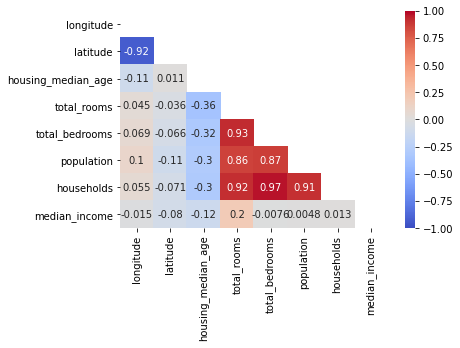

In [83]:
corr_columns = [c for c in num_columns if c != 'median_house_value']

vector_col = 'corr_features'
assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
df_vector = assembler.setHandleInvalid("skip").transform(df[corr_columns]).select(vector_col)

#создаем матрицу
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

matrix_df = pd.DataFrame(cor_np, columns=corr_columns)
matrix_df.index = corr_columns

matrix_mask = np.triu(matrix_df)
sns.heatmap(matrix_df,
           annot=True,
     mask=matrix_mask,
              vmin=-1,
               vmax=1,
      cmap='coolwarm')
plt.show()

Найдём жилые массивы, в которых живут самые обеспеченные люди. 

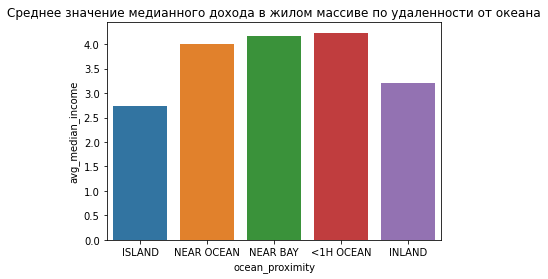

In [84]:
df_wealthy = df.groupBy('ocean_proximity').agg(F.avg('median_income').alias('avg_median_income')).toPandas()
df_wealthy
bar = sns.barplot(data = df_wealthy, x='ocean_proximity', y='avg_median_income')
bar.set_title('Среднее значение медианного дохода в жилом массиве по удаленности от океана')
plt.show()

Сгруппируем данные по столбцу с категориями удалённости от океана и посчитаем среднее значение медианного дохода в жилом массиве:

In [85]:
df_wealthy = df.groupBy('ocean_proximity').agg(F.avg('median_income').alias('avg_median_income')).toPandas()
df_wealthy

,ocean_proximity,avg_median_income
0,ISLAND,2.744420
1,NEAR OCEAN,4.005785
2,NEAR BAY,4.172885
3,<1H OCEAN,4.230682
4,INLAND,3.208996


Таким образом, мы видим, что люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива.

 Исследуем зависимость возраста жителей от удалённости жилого массива от океана.

In [86]:
df_ages = df.groupBy('housing_median_age', 'ocean_proximity').agg({'housing_median_age':'count'}).toPandas()
df_ages = df_ages.rename({'count(housing_median_age)':'count_households'},axis=1)
df_ages.head()

,housing_median_age,ocean_proximity,count_households
0,23.0,<1H OCEAN,195
1,31.0,NEAR BAY,41
2,11.0,<1H OCEAN,83
3,36.0,<1H OCEAN,477
4,10.0,INLAND,151


<AxesSubplot:xlabel='housing_median_age', ylabel='count(housing_median_age)'>

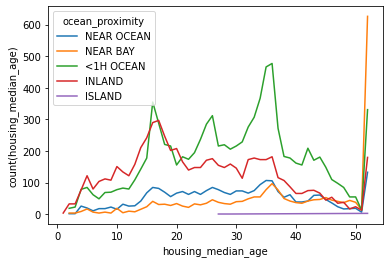

In [87]:
df_ages = df.groupBy(['ocean_proximity', 'housing_median_age']).agg(F.count('housing_median_age')).toPandas()

sns.lineplot(data=df_ages, 
    x='housing_median_age', 
    y='count(housing_median_age)', 
    hue='ocean_proximity'
            )

По графику можно предположить, что люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива.



***Выводы:***


- В столбце total_bedrooms есть пропуски, которые были заполнены медианным значением;
- В данных есть выбросы. Если при обучении модели наличие выбросов будет серьезно искажать результаты, то от них стоит избавиться.
- Высокой корреляцией между собой: количество домовладений в массиве и количество спален, наряду с количеством комнат и количество человек, которые проживают в жилом массиве. 

Итак, мы создали новые признаки для модели машинного обучения. Начинаем подготовку к обучению моделей. Разделим колонки на два типа: числовые и текстовые, которые представляют категориальные данные.

### Трансформация признаков

In [88]:
stages = []

categoricalColumns = ['ocean_proximity']
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol,
                                  outputCol = categoricalCol + 'Index',
                                  handleInvalid = 'keep')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=categoricalCol + "classVec")
    stages += [stringIndexer, encoder]

numericCols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler_all = VectorAssembler(inputCols=assemblerInputs, outputCol='features')

stages += [assembler_all]

Обучение модели на данных с сохранением категориальных данных

In [89]:
target = 'median_house_value'

train, test = df.randomSplit([.8,.2], seed=12345)
print(f'Обучающая выборка содержит: {train.count()} строк, {len(train.columns)} столбцов',
      f'Тестовая выборка содержит: {test.count()} строк, {len(test.columns)} столбцов')

Обучающая выборка содержит: 16431 строк, 10 столбцов Тестовая выборка содержит: 4209 строк, 10 столбцов


Финальный шаг преобразований — это объединение признаков в один вектор, с которым ML-алгоритм умеет работать.

На этапе обучения моделей нам предстоит построить две модели линейной регрессии на разных наборах данных:

- используя все данные из файла;
- используя только числовые переменные, исключив категориальные.

необходимо подготовить дополнительный датасет, из которого исключены категориальные признаки

В процессе загрузки датасетов, пребобработки данных и трансформации признаков было выявлено:

- Проверены пропуски (найдено 207 пропусков в столбец total_bedrooms), строки, в которых есть пропущенные значения были заменены на медианные значения.
- Найдены жилые массивы, в которых живут самые обеспеченные люди, сгруппированы данные по столбцу с категориями удалённости от океана и посчитано среднее значение медианного дохода в жилом массиве. На основе полученных данных можно сделать вывод, что люди с высоким доходом предпочитают селиться в жилых массивах, которые находятся не более чем в часе езды до океана или около залива.
- Исследована зависимость возраста жителей от удалённости жилого массива от океана и сгруппированы данные по двум столбцам: медианный возраст жителей и удалённость от океана, а потом было посчитано, сколько раз встречается то или иное медианное значение возраста в зависимости от удалённости от океана. Построен график, по которому можно предположить, что люди до 20 лет чаще живут в материковой части Калифорнии (INLAND) и в радиусе часа езды до океана. Старшие поколения предпочитают селиться в радиусе часа езды до океана и около залива.
- Созданы несколько новых столбцов с признаками:
- Отношение количества комнат total_rooms к количеству домовладений households. Столбец rooms_per_household.
- Отношение количества жителей population к количеству домовладений households. Столбец population_in_household.
- Отношение количества спален total_bedrooms к общему количеству комнат total_rooms. Столбец bedroom_index

# Обучение моделей

**Обучаем модель на всех данных**

In [90]:
lr_all = LinearRegression(labelCol='median_house_value', featuresCol='features')
stages += [lr_all]

In [91]:
pipeline_all = Pipeline(stages=stages)

In [92]:
model_all = pipeline_all.fit(train)

23/03/22 13:45:16 WARN Instrumentation: [d7e17e7e] regParam is zero, which might cause numerical instability and overfitting.
23/03/22 13:45:16 WARN Instrumentation: [d7e17e7e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [93]:
predictions_all = model_all.transform(test)
predictedLabes_all = predictions_all.select('median_house_value', 'prediction')
predictedLabes_all.show(5) 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          106700.0|216239.41686426103|
|          128900.0|207043.64720275532|
|          116100.0| 233374.9593785298|
|           70500.0|162953.64382442273|
|           85600.0|187631.63073280314|
+------------------+------------------+
only showing top 5 rows



**Чтобы убедиться в этом - проверим модель на тестовых данных.**

**Обучаем модель на числовых данных**

In [94]:
assemblerInputs_num = numericCols
assembler_num = VectorAssembler(inputCols=assemblerInputs_num, outputCol='features')
stages[2] = assembler_num

In [95]:
pipeline_num = Pipeline(stages=stages)

In [96]:
model = pipeline_num.fit(train)

23/03/22 13:45:18 WARN Instrumentation: [699d93d2] regParam is zero, which might cause numerical instability and overfitting.


In [97]:
predictions_num = model.transform(test)
predictedLabes_num = predictions_num.select('median_house_value', 'prediction')
predictedLabes_num.show(5)

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          106700.0|189494.01957265427|
|          128900.0| 174156.0727373734|
|          116100.0|200522.64080975205|
|           70500.0|130308.13793004258|
|           85600.0| 155216.9923943635|
+------------------+------------------+
only showing top 5 rows



Сопоставив полученные метрики модели, обученной на полном наборе данных и модели, обученной исключтельно на числовых признаках, приходим к следующим выводам:
- r2: 0.63 говорит нам о том, что кол-во отклонений на нашей модели, зависящих от набора данных составляет 0.01 (0.63 vs 0.64);
- модель, основанная на числовых признаках, предсказывает цены на жильё до 69847, против 68788 в модели, основанной на всем наборе признаков.

# Анализ результатов

In [98]:
results = []

In [99]:
def all_metrics(pred_data, model_name):
    rmse = RegressionEvaluator(predictionCol="prediction", labelCol="median_house_value", metricName='rmse').evaluate(pred_data)
    mae = RegressionEvaluator(predictionCol="prediction", labelCol="median_house_value", metricName='mae').evaluate(pred_data)
    r2 = RegressionEvaluator(predictionCol="prediction", labelCol="median_house_value", metricName='r2').evaluate(pred_data)
    return model_name, rmse, mae, r2

In [100]:
results.append(all_metrics(predictedLabes_all,'features'))
results.append(all_metrics(predictedLabes_num, 'numerical_features'))

In [101]:
results = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2'])
results.style.highlight_min(axis = 0)

,Model,RMSE,MAE,R2
0,features,67710.875001,49104.504959,0.658834
1,numerical_features,68813.706770,50311.017851,0.647630


In [ ]:
spark.stop()

Нами проведено обучение 2-х моделей, с использованием 2-х наборов признаков:
- всех признаков датасета (all_features);
- только числовых признаков датасета (numerical_features_scaled).

По итогам обучения можно сделать вывод, что отличия моделей потенциально не значимы и обе модели практически одинаково предсказывают целевой признак.